##### Change Notebook Width:

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

##### Disable Autoscrolling in Cells:

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# 1. Prepare

In [3]:
import os
import io
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage as sk
import pandas as pd
import cv2
import seaborn as sns

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

from imports.utils.log_progress import log_progress
from imports.utils.visualization import Visualize
from imports.utils.enums import DATA_BASE_PATH, RAW_PATH, SHAPE
from imports.utils.utils import rle_encode, rle_decode

from PIL import Image
from PIL import ImageDraw
from matplotlib.pyplot import imshow, imread, imsave
from skimage.draw import line, line_aa, circle
from skimage.util import img_as_float

import xml.etree.ElementTree as ET
import base64
import warnings
warnings.filterwarnings("ignore")

# 2. Read XML's: 

In [4]:
def get_masks_from_xml(xml_tree):
    root = xml_tree.getroot()
    itemlist = root.findall("./ParameterNode/Labels/Item/Value/")
    masks = []
    for item in itemlist:
        if item.attrib["Type"] == "csem.Vision.Labels.FreeFormLabel":
            mask_entry = item.findall("./Mask")
            masks.append(mask_entry[0].text)
    return masks

def get_roots_from_xml(xml_tree):
    root = xml_tree.getroot()
    itemlist = root.findall("./ParameterNode/Labels/Item/Value/")
    roots = []
    for item in itemlist:
        if item.attrib['Type'] == "csem.Vision.Labels.CircularLabel":
            root_entry = item.findall("./BaseClass/Location")
            pX = float(root_entry[0].text.split(",")[0].replace("(",""))
            pY = float(root_entry[0].text.split(",")[1].replace(")",""))
            roots.append([pX,pY])
    return roots

def get_polygons_from_xml(xml_tree):
    root = xml_tree.getroot()
    itemlist = root.findall("./ParameterNode/Labels/Item/Value/")
    splines = []
    for item in itemlist:
        if item.attrib["Type"] == "csem.Vision.Labels.PolygonLabel":
            polygon_entry = item.findall("./Points/Item")
            spline = []
            for p in polygon_entry:  
                pX = float(p.text.split(",")[0].replace("(",""))
                pY = float(p.text.split(",")[1].replace(")",""))
                spline.append([pX,pY])
            splines.append(spline)
    return splines
            

def create_mask(mask_strings,size,min_size=10000):
    merged_masks = np.zeros(size,dtype=bool)
    if not len(mask_strings) >= 1:
        return merged_masks
    
    mask_as_bytes = base64.b64decode(mask_strings[0])
    mask = Image.open(io.BytesIO(mask_as_bytes))
    
    for string in mask_strings:
        mask_as_bytes = base64.b64decode(string)
        mask = Image.open(io.BytesIO(mask_as_bytes))
        'Skip masks which are below min_size:'
        if np.sum(np.array(mask) > 0) > min_size:
            merged_masks += np.array(mask) > 0
    return merged_masks
    
    
def create_df():
    imagelist = []
    for path, subdirs, files in os.walk(RAW_PATH):
        for name in files:
            if name.endswith(".png"):
                fullpath = os.path.join(path, name)
                xmlpath = fullpath[:-4]+".xml"
                imagelist.append((path,name,fullpath,xmlpath))
                
    vals = [[] for i in range(6)]
    
    for path,name,fullpath,xmlpath in log_progress(imagelist,every=1):
        img = Image.open(fullpath,mode="r")
        width, height = img.size
        tree = ET.parse(xmlpath)
        masks = get_masks_from_xml(tree)
        mask = create_mask(masks,(height,width))
        rle = rle_encode(mask)
        roots = get_roots_from_xml(tree)
        splines = get_polygons_from_xml(tree)
        vals[0].append(path)
        vals[1].append(name)
        vals[2].append(rle)
        vals[3].append(roots)
        vals[4].append(splines)
        vals[5].append((height,width))

            
    files = {"Path":vals[0],
             "Name":vals[1],
             "Rle-Encoding":vals[2],
             "Roots":vals[3],
             "Splines":vals[4],
             "Shape":vals[5]}
    df = pd.DataFrame.from_dict(files)
    return df

In [5]:
tree0 = ET.parse(RAW_PATH+'Prozessschritte_01/DSC_0015 (3).xml')

FileNotFoundError: [Errno 2] No such file or directory: '../data/LabelingTool/Prozessschritte_01/DSC_0015 (3).xml'

In [ ]:
splines = get_polygons_from_xml(tree0)
splines[0]

### Load Existing Dataframe

In [6]:
df = pd.read_pickle(DATA_BASE_PATH+'/df')

### Create Dataframe of "Raw" Data:

In [66]:
df = create_df()

### Split df into Subsets and save to folders:

In [7]:
import math
df_shuffeled = df.sample(frac=1)
train_size = 0.7
val_size = 0.25
test_size = 0.05
samples = len(df_shuffeled)

train_ind = math.floor(samples*train_size)
val_ind = train_ind + math.floor(samples*val_size)
test_ind = train_ind + val_ind + math.floor(samples*test_size)

train_df = df_shuffeled[0:train_ind].reset_index(drop=True)
val_df = df_shuffeled[train_ind:val_ind+1].reset_index(drop=True)
test_df = df_shuffeled[val_ind:-1].reset_index(drop=True)

print("All Samples: " + str(len(df_shuffeled)))
print("Training Samples: " + str(len(train_df)))
print("Validation Samples: " + str(len(val_df)))
print("Testing Samples: " + str(len(test_df)))

train_df.to_pickle(DATA_BASE_PATH+"/train_df")
val_df.to_pickle(DATA_BASE_PATH+"/val_df")
test_df.to_pickle(DATA_BASE_PATH+"/test_df")

All Samples: 507
Training Samples: 354
Validation Samples: 127
Testing Samples: 26


### Save Dataframe of "Raw" Data:

In [68]:
df.to_pickle(DATA_BASE_PATH+"/df")

### Show Samples of DataFrame:

In [10]:
df.sample(3)

Path  \
286  ../data/LabelingTool/Prozessschritte_06   
204  ../data/LabelingTool/Prozessschritte_04   
107  ../data/LabelingTool/Prozessschritte_03   

                                 Name  \
286  20160914D_hamt080_Ampfer-raw.png   
204  20160913D_hamt176_Ampfer-raw.png   
107  20160913D_hamt074_Ampfer-raw.png   

                                          Rle-Encoding  \
286  458638 2 459784 12 460933 16 462082 20 463232 ...   
204  336527 2 338261 10 339997 14 341734 17 343471 ...   
107  367926 4 369659 14 371396 16 373132 20 374869 ...   

                                                 Roots  \
286  [[518.2488, 750.1774], [1039.649, 1209.506], [...   
204  [[424.6569, 830.919], [649.6407, 544.0646], [8...   
107       [[895.7167, 432.9789], [19.09637, 1107.775]]   

                                               Splines         Shape  
286  [[[210.3658, 696.5485], [235.6093, 711.6946]],...  (1738, 1151)  
204  [[[212.7763, 725.1216], [373.5438, 791.6281]],...  (1151, 1738)  
107  [[[77.63641, 1007.188], [116.8911, 979.9095], ...  (1151, 1738)

### Show Mask at Index:

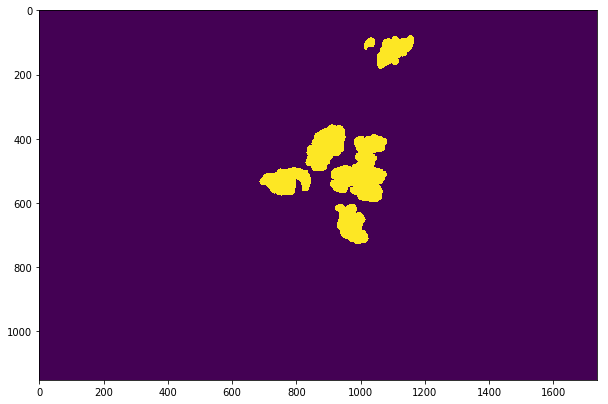

In [8]:
index = 170
mask = rle_decode(df['Rle-Encoding'][index], df['Shape'][index])
plt.figure(figsize=(10,10))
imshow(mask)

### Show Image at Index:

In [9]:
image = imread(df['Path'][index] + "/" + df['Name'][index])
plt.figure(figsize=(10,10))
imshow(image)

FileNotFoundError: [Errno 2] No such file or directory: '../data/LabelingTool/Prozessschritte_04/20160913D_hamt141_Ampfer-raw.png'

### Show Lines:

In [10]:
def draw_splines(splines,shape):
    img = np.zeros(shape, dtype=np.uint8)
    for spline in splines:
        s = len(spline)
        for i in range(s-1):
            rr, cc, val = line_aa(int(spline[i][1]), int(spline[i][0]), int(spline[i+1][1]),int(spline[i+1][0]))
            img[rr, cc] = val*255
    return img
   
splines = draw_splines(df['Splines'][index],df['Shape'][index])
plt.figure(figsize=(20,20))
imshow(image)
imshow(splines,cmap='terrain',alpha=0.6)

NameError: name 'image' is not defined

<Figure size 1440x1440 with 0 Axes>

### Show Roots:

In [11]:
def draw_roots(roots,shape):
    img = np.zeros(shape, dtype=np.uint8)
    for root in roots:
            rr, cc = circle(int(root[1]),int(root[0]),max(shape)/100)
            img[rr, cc] = 1
    return img

roots = draw_roots(df['Roots'][index],df['Shape'][index])
plt.figure(figsize=(20,20))
imshow(image)
imshow(roots,cmap='terrain',alpha=0.6)

NameError: name 'image' is not defined

<Figure size 1440x1440 with 0 Axes>

# 3. Save as Standardized Images and Masks:

In [12]:
# Rotates and Resizes Image, Mask, Roots and Splines:
def rotate_and_resize(im,msk,roots,lines,output_size=(1024,1536),scale_factor=1.0,rotate_angle=90):
    #from: https://stackoverflow.com/questions/11764575/python-2-7-3-opencv-2-4-after-rotation-window-doesnt-fit-image
    
    assert rotate_angle == 90 or rotate_angle == 0, "rotate_angle must be 0 or 90°"
    
    oldY = im.shape[0] #note: numpy uses (y,x) convention but most OpenCV functions use (x,y)
    oldX = im.shape[1]
    M = cv2.getRotationMatrix2D(center=(oldX/2,oldY/2), angle=rotate_angle, scale=scale_factor) #rotate about center of image.

    #choose a new image size.
    newX,newY = oldX*scale_factor,oldY*scale_factor
    
    #include this if you want to prevent corners being cut off
    r = np.deg2rad(rotate_angle)
    newX,newY = (abs(np.sin(r)*newY) + abs(np.cos(r)*newX),abs(np.sin(r)*newX) + abs(np.cos(r)*newY))

    #So I will find the translation that moves the result to the center of that region.
    (tx,ty) = ((newX-oldX)/2,(newY-oldY)/2)
    M[0,2] += tx #third column of matrix holds translation, which takes effect after rotation.
    M[1,2] += ty
    
    # Transform image and mask
    im_rotated = cv2.warpAffine(im, M, dsize=(int(newX),int(newY)))
    msk_rotated = cv2.warpAffine(msk, M, dsize=(int(newX),int(newY)))
    
    transformed_lines = []
    for line in lines:
        ones_line = np.ones(shape=(len(line), 1))
        line_ones = np.hstack([line, ones_line])
        transformed_lines.append(M.dot(line_ones.T).T) 
    
    # add ones
    ones_roots = np.ones(shape=(len(roots), 1))

    roots_ones = np.hstack([roots, ones_roots])

    # transform roots and lines
    transformed_roots = M.dot(roots_ones.T).T
    
    if (oldY < oldX and rotate_angle==0) or (oldY > oldX and rotate_angle==90):
        output_size= (output_size[1],output_size[0])
    
    # resize image, mask and roots
    shape_old = im_rotated.shape
    im_rotated = cv2.resize(im_rotated,output_size, interpolation = cv2.INTER_CUBIC)
    msk_rotated = cv2.resize(msk_rotated,output_size, interpolation = cv2.INTER_CUBIC)
    
    ratioX = shape_old[1]/im_rotated.shape[1]
    ratioY = shape_old[0]/im_rotated.shape[0]
    for root in transformed_roots:
        root[0] = root[0] / ratioY
        root[1] = root[1] / ratioX
    for lines in transformed_lines:
        for line in lines:
            line[0] = line[0] / ratioY
            line[1] = line[1] / ratioX
    
    # make sure the image and mask is in range [0,1]
    im_rotated = im_rotated/im_rotated.max()
    msk_rotated = msk_rotated/msk_rotated.max()
    
    return im_rotated, msk_rotated, transformed_roots, transformed_lines

In [13]:
# Show sample:

index = 11

mask = rle_decode(df['Rle-Encoding'][index], df['Shape'][index])
image = imread(df['Path'][index] + "/" + df['Name'][index])

roots = df['Roots'][index]
lines = df['Splines'][index]

plt.figure(figsize=(15,15))
rotated_im, rotated_msk, rotated_roots, rotated_lines = rotate_and_resize(image,mask,roots,lines,rotate_angle=0)

imshow(rotated_im)
imshow(draw_roots(rotated_roots,(rotated_im.shape[0],rotated_im.shape[1])),cmap='jet',alpha=0.8)
imshow(draw_splines(rotated_lines,(rotated_im.shape[0],rotated_im.shape[1])),cmap='terrain',alpha=0.6)
imshow(rotated_msk,cmap='terrain',alpha=0.3)

FileNotFoundError: [Errno 2] No such file or directory: '../data/LabelingTool/Prozessschritte_01/20160913D_hamt010_Ampfer-raw.png'

### Save Data and Create new Dataframe

In [44]:
def save_data(dataframes):
    i = 0
    vals = [[] for i in range(9)]
    for key, df in dataframes.items():
        print('Processing: ' + str(key))
        for index, image in log_progress(df.iterrows(),every=1,size=len(df)):
            read_path = os.path.join(image['Path'],image['Name'])
            im = imread(read_path)
            msk = rle_decode(image['Rle-Encoding'], image['Shape'])
                
            roots = image['Roots']
            splines = image['Splines']
                
            if image['Shape'][0] > image['Shape'][1]:
                im, msk, roots, splines = rotate_and_resize(im,msk,roots,splines,output_size=(1024,1536),rotate_angle=90)
            else:
                im, msk, roots, splines = rotate_and_resize(im,msk,roots,splines,output_size=(1024,1536),rotate_angle=0)
           
            msk_auto_gen = np.zeros(im.shape, dtype=np.uint8)
            for root in roots:
                rr, cc = circle(int(root[1]), int(root[0]), max(im.shape[0],im.shape[1])/10)
                try:
                    msk_auto_gen[rr, cc] = 255
                except:
                    pass
            sk.img_as_float(msk_auto_gen)
            
            if key == 'all_df':
                save_path = '../data/00_train_all/'
                data_set = 'None'
            if key == 'train_df':
                save_path = '../data/01_train/'
                data_set = 'train'
            if key == 'val_df':
                save_path = '../data/03_val/'
                data_set = 'val'
            if key == 'test_df':
                save_path = '../data/04_test/'
                data_set = 'test'
                
            name = "img_" + str(1000+i) + ".png"
            image_path = save_path+'images/'
            mask_path = save_path+'masks/'
            mask_circle_path = save_path+'masks_autogen/'
            
            vals[0].append(image_path)
            vals[1].append(mask_path)
            vals[2].append(mask_circle_path)
            vals[3].append(name)
            vals[4].append(data_set)
            vals[5].append(rle_encode(msk>0.5))
            vals[6].append(rle_encode(msk_auto_gen>0.5))
            vals[7].append(roots)
            vals[8].append(splines)
                
            sk.io.imsave(image_path + name,im)
            sk.io.imsave(mask_path + name,msk)
            sk.io.imsave(mask_circle_path + name,msk_auto_gen)
            i+=1
            
    files = {"image_path":vals[0],
             "mask_path":vals[1],
             "mask_cirlce_path":vals[2],
             "name":vals[3],
             "dataset":vals[4],
             "mask_rle":vals[5],
             "mask_circle_rle":vals[6],
             "roots":vals[7],
             "splines":vals[8]}
    return pd.DataFrame.from_dict(files)

### Load splitted Dataframes:

In [19]:
train_df = pd.read_pickle(DATA_BASE_PATH+'/train_df')
val_df = pd.read_pickle(DATA_BASE_PATH+'/val_df')
test_df = pd.read_pickle(DATA_BASE_PATH+'/test_df')

In [35]:
dataframes = {
    "train_df" : train_df,
    "val_df" : val_df,
    "test_df" : test_df}

In [45]:
dataframes = {
    "all_df" : df}

### Save:

In [46]:
new_df = save_data(dataframes)

Processing: all_df


In [47]:
new_df.sample(3)

image_path                    mask_path  \
63   ../data/00_train_all/images/  ../data/00_train_all/masks/   
33   ../data/00_train_all/images/  ../data/00_train_all/masks/   
305  ../data/00_train_all/images/  ../data/00_train_all/masks/   

                        mask_cirlce_path          name dataset  \
63   ../data/00_train_all/masks_autogen/  img_1063.png    None   
33   ../data/00_train_all/masks_autogen/  img_1033.png    None   
305  ../data/00_train_all/masks_autogen/  img_1305.png    None   

                                              mask_rle  \
63   446177 2 447710 8 449245 11 450780 15 452315 2...   
33   456919 10 458450 27 459982 33 461515 36 463049...   
305  616187 6 617720 15 619253 22 620787 27 622322 ...   

                                       mask_circle_rle  \
63   1831783 81 1836364 135 1840954 171 1845547 201...   
33   1310383 81 1314964 135 1319554 171 1324147 201...   
305  1398649 81 1403230 135 1407820 171 1412413 201...   

                                                 roots  \
63             [[815.420719374457, 550.4958600690449]]   
33   [[583.2551024390244, 437.6457623282135], [659....   
305  [[821.4278005212858, 456.9355194476409], [280....   

                                               splines  
63   [[[836.368503214596, 581.7095364787111], [855....  
33   [[[653.189931707317, 586.549600646726], [620.5...  
305  [[[167.05158783666377, 535.6453560414269], [20...

### Load Existing:

In [21]:
new_df = pd.read_pickle(DATA_BASE_PATH+'/new_df')

In [22]:
new_df.sample(3)

image_path                    mask_path  \
416  ../data/00_train_all/images/  ../data/00_train_all/masks/   
49   ../data/00_train_all/images/  ../data/00_train_all/masks/   
404  ../data/00_train_all/images/  ../data/00_train_all/masks/   

                        mask_cirlce_path          name dataset  \
416  ../data/00_train_all/masks_autogen/  img_1416.png    None   
49   ../data/00_train_all/masks_autogen/  img_1049.png    None   
404  ../data/00_train_all/masks_autogen/  img_1404.png    None   

                                              mask_rle  \
416  237436 3 238968 11 240503 13 242038 15 243573 ...   
49   844527 16 846061 23 847596 26 849132 29 850668...   
404  419953 11 421484 21 423020 23 424554 26 426089...   

                                       mask_circle_rle  \
416  154825 81 159406 135 163996 171 168589 201 173...   
49   2962435 81 2967016 135 2971606 171 2976199 201...   
404  1596187 81 1600768 135 1605358 171 1609951 201...   

                                                 roots  \
416  [[666.2789004344048, 585.8006168009206], [801....   
49   [[1427.6851512195121, 746.544892481811], [1379...   
404           [[619.2016792354475, 499.3667682393555]]   

                                               splines  
416  [[[562.148064639444, 647.5114936708861], [601....  
49   [[[1390.073756097561, 1017.4902359126921], [13...  
404  [[[413.07537237185056, 394.98787940161105], [5...

In [48]:
new_df.to_pickle(DATA_BASE_PATH+"/new_df")

# 4. Show Samples of "processed" Data:

In [158]:
vis_params = {'data_set':'train',
              'model':None}

visualize = Visualize(**vis_params)

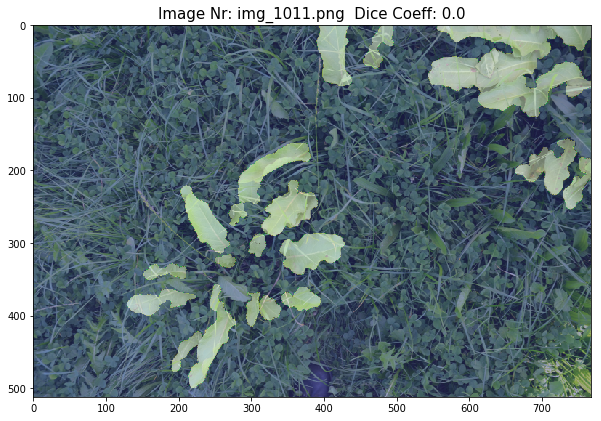

In [159]:
_,_ = visualize.show_single(index=1011,mode='image_mask')

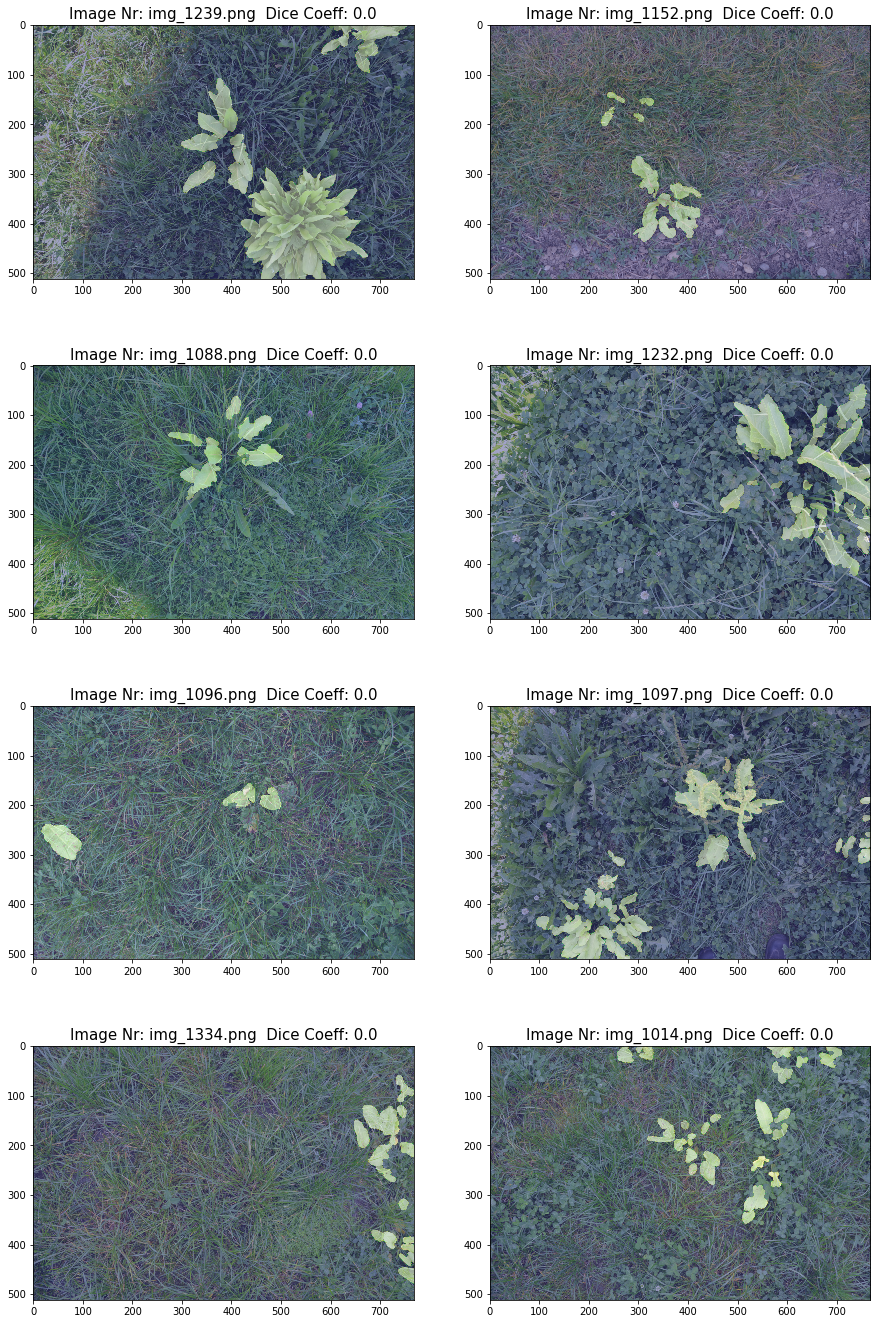

In [160]:
visualize.show_matrix(index='random',mode='image_mask')

### 4.1 Visualize Root Distribution:

In [23]:
# shuffle
import math
df_shuffeled = new_df.sample(frac=1)
train_size = 0.7
val_size = 0.2
test_size = 0.1
samples = len(df_shuffeled)

train_ind = math.floor(samples*train_size)
val_ind = train_ind + math.floor(samples*val_size)
test_ind = train_ind + val_ind + math.floor(samples*test_size)

train_df = df_shuffeled[0:train_ind].reset_index(drop=True)
val_df = df_shuffeled[train_ind:val_ind+1].reset_index(drop=True)
test_df = df_shuffeled[val_ind:-1].reset_index(drop=True)

print("Number of training Samples:", len(train_df))
print("Number of validation Samples:", len(val_df))
print("Number of test Samples:", len(test_df))

Number of training Samples: 354
Number of validation Samples: 102
Number of test Samples: 51


### Save:

In [24]:
train_df.to_pickle(DATA_BASE_PATH+"/new_train_df")
val_df.to_pickle(DATA_BASE_PATH+"/new_val_df")
test_df.to_pickle(DATA_BASE_PATH+"/new_test_df")

In [63]:
df_all = pd.concat([train_df.assign(dataset='train'), val_df.assign(dataset='val'), test_df.assign(dataset='test')])

Text(0.5,1,'Distribution of Roots per Image')

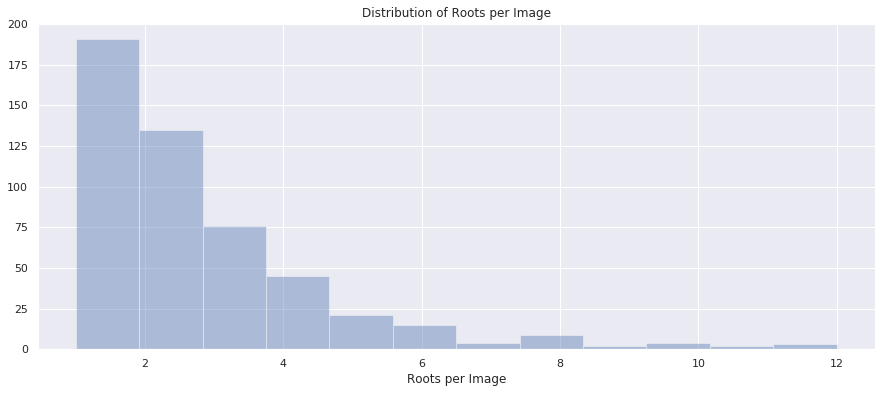

In [108]:
x = df_all[['roots']].apply (lambda row: len(row['roots']), axis=1)
x = pd.Series(x, name="Roots per Image")
plt.figure(figsize=(15,6))
sns.distplot(x,bins=12, kde=False, rug=False).set_title("Distribution of Roots per Image")

In [39]:
#create temporary dataframe:
x_roots = []
y_roots = []
paths = []
for _,row in df_all.iterrows():
    for root in row['roots']:
        x_roots.append(root[0])
        y_roots.append(root[1])
        paths.append(row['dataset'])
        
root_coordinates = [('x', x_roots),
                 ('y', y_roots),
                    ('dataset',paths)]
df_root_coordinates = pd.DataFrame.from_items(root_coordinates)
df_root_coordinates.sample(3)

x           y dataset
1215   816.885635  158.842727    test
259    557.517022  445.195725   train
1068  1222.434474  979.891995     val

Text(0.5,1,'Distribution of Root-Coordinates in Images')

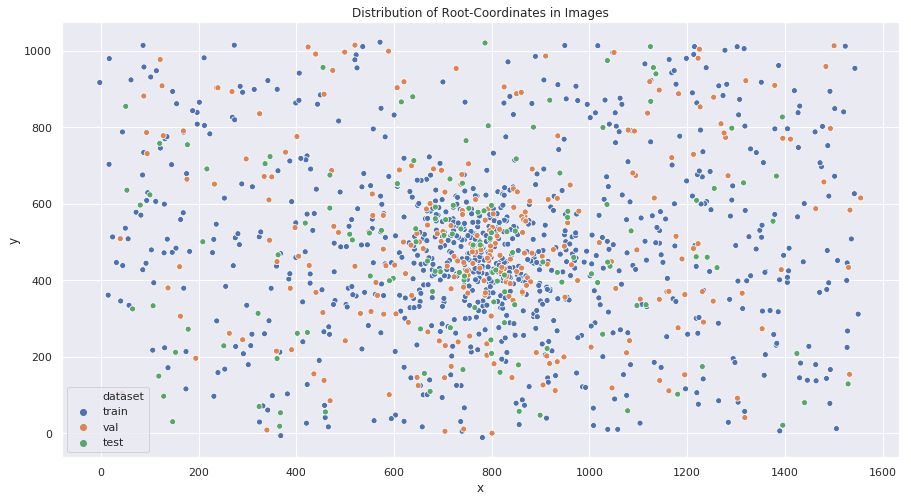

In [41]:
plt.figure(figsize=(15,8))
sns.set(style="darkgrid")
ax = sns.scatterplot(x="x", y="y",hue="dataset", data=df_root_coordinates)
ax.set_title("Distribution of Root-Coordinates in Images")

<Figure size 1080x576 with 0 Axes>

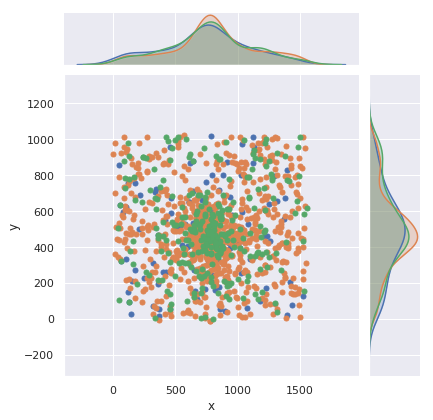

In [42]:
plt.figure(figsize=(15,8))
g = sns.JointGrid("x", "y", df_root_coordinates)
for datatype, data in df_root_coordinates.groupby("dataset"):
    sns.kdeplot(data["x"], ax=g.ax_marg_x, legend=False, shade=True)
    sns.kdeplot(data["y"], ax=g.ax_marg_y, vertical=True, legend=False, shade=True)
    g.ax_joint.plot(data["x"], data["y"], "o", ms=5)

<Figure size 1080x576 with 0 Axes>

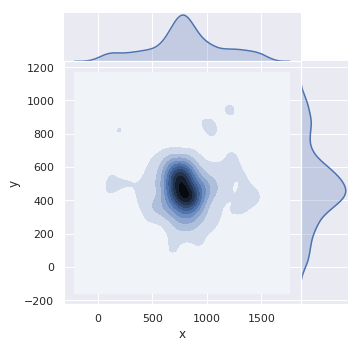

In [43]:
plt.figure(figsize=(15,8))
g = sns.jointplot(df_root_coordinates.loc[df_root_coordinates['dataset'] == 'train'].x,
                  df_root_coordinates.loc[df_root_coordinates['dataset'] == 'train'].y,
                  kind="kde", height=5, space=0)

### 4.2 Visualize Mask Distribution:

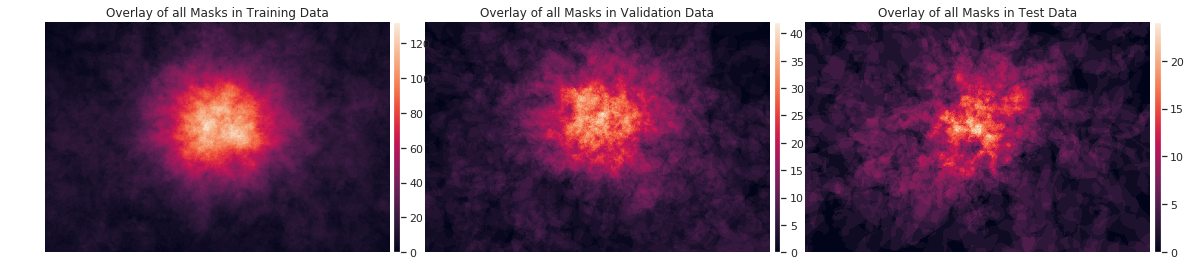

In [47]:
shape = (1024,1536)
summed_mask_train = np.zeros(shape)
summed_mask_val = np.zeros(shape)
summed_mask_test = np.zeros(shape)
for i,row in df_all.iterrows():
    if row['dataset'] == 'train':
        summed_mask_train += rle_decode(row['mask_rle'],shape)
    if row['dataset'] == 'val':
        summed_mask_val += rle_decode(row['mask_rle'],shape)
    if row['dataset'] == 'test':
        summed_mask_test += rle_decode(row['mask_rle'],shape)

from mpl_toolkits.axes_grid1 import make_axes_locatable        
        
fig, axs = plt.subplots(ncols=3,nrows=1,figsize=(20,20))
im0 = axs[0].imshow(summed_mask_train)
im1 = axs[1].imshow(summed_mask_val)
im2 = axs[2].imshow(summed_mask_test)
axs[0].set_title('Overlay of all Masks in Training Data')
axs[0].axis('off')
axs[1].set_title('Overlay of all Masks in Validation Data')
axs[1].axis('off')
axs[2].set_title('Overlay of all Masks in Test Data')
axs[2].axis('off')

divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='2%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='2%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='2%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')


plt.subplots_adjust(wspace=0.07, hspace=0)

# 5. Data Augmentation:

In [17]:
# Based on https://github.com/aleju/imgaug-doc/tree/master/notebooks

import skimage
import imgaug as ia
from imgaug import augmenters as iaa
from skimage.transform import rescale, resize

class Data_Augmentation():
    def __init__(self,batch_size,target_size,image_path,nb_batches=1):
        self.batch_size = batch_size
        self.nb_batches = nb_batches
        self.target_size = target_size
        self.image_path = image_path
        self.index = 0
        self.file_list = os.listdir(DATA_BASE_PATH+self.image_path)
        print("Generating " + str(len(self.file_list*self.batch_size*self.nb_batches)) + " Images out of " + str(len(self.file_list)))

    def generate_augmented_images(self):
        for file in self.file_list:
            image = imread(DATA_BASE_PATH+'/01_train/images/'+file)
            mask = imread(DATA_BASE_PATH+'/01_train/masks/'+file)
            mask_circle = imread(DATA_BASE_PATH+'/01_train/masks_autogen/'+file)
            batch_image_aug, batch_mask_aug, batch_mask_circle_aug = self.augment_image_batch(image,mask,mask_circle)
            self.__save_batches(batch_image_aug,batch_mask_aug,batch_mask_circle_aug) 
        
    def augment_image_batch(self,image,mask,mask_circle):
        image = resize(image,(self.target_size[0],self.target_size[1]))
        image = skimage.img_as_ubyte(image) #Image needed as int8
        images = [np.copy(image) for _ in range(self.batch_size)]
        image_batches = [ia.Batch(images=images) for _ in range(self.nb_batches)]

        mask = resize(mask,(self.target_size[0],self.target_size[1])).astype('float32')
        mask = skimage.img_as_ubyte(mask) #Image needed as int8
        masks = [np.copy(mask) for _ in range(self.batch_size)]
        mask_batches = [ia.Batch(images=masks) for _ in range(self.nb_batches)]

        mask_circle = resize(mask_circle,(self.target_size[0],self.target_size[1])).astype('float32')
        mask_circle = skimage.img_as_ubyte(mask_circle) #Image needed as int8
        mask_circle = [np.copy(mask_circle) for _ in range(self.batch_size)]
        mask_circle_batches = [ia.Batch(images=mask_circle) for _ in range(self.nb_batches)]

        aug = iaa.Sequential([
            iaa.SomeOf((0, 4), [ #Apply 0 to 4 operations of the following:
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Fliplr(0.8),
                iaa.Flipud(0.8),
                iaa.Affine(rotate=(-45, 45)),  # rotate by -45 to 45 degrees (affects heatmaps)
                iaa.Add((-50, 50), per_channel=0.7),
                iaa.PiecewiseAffine(scale=(0.01, 0.05)),
                iaa.GammaContrast(gamma=0.4,per_channel=False)
            ]),
        ], random_order=True)

        aug = aug.to_deterministic() #Apply same operations to image and mask
        batch_image_aug = list(aug.augment_batches(image_batches, background=True))  # background=True for multicore aug
        batch_mask_aug = list(aug.augment_batches(mask_batches, background=True))
        batch_mask_circle_aug = list(aug.augment_batches(mask_circle_batches, background=True))
        return batch_image_aug, batch_mask_aug, batch_mask_circle_aug

    def __save_batches(self,batch_image_aug,batch_mask_aug,batch_mask_circle_aug):
        save_path = DATA_BASE_PATH+'/02_augmented'
        for batch in range(NB_BATCHES):
            for image in range(BATCH_SIZE):
                im = skimage.img_as_float(batch_image_aug[batch].images_aug[image])
                ms = skimage.img_as_float(batch_mask_aug[batch].images_aug[image])
                ms = skimage.color.rgb2gray(ms)
                ms = ms > 0.5
                ms = skimage.img_as_float(ms)
                ms_circle = skimage.img_as_float(batch_mask_circle_aug[batch].images_aug[image])
                ms_circle = skimage.color.rgb2gray(ms_circle)
                ms_circle = ms_circle > 0.5
                ms_circle = skimage.img_as_float(ms_circle)
                #print(ms.shape)
                imsave(save_path+"/images/aug_"+str(10000+self.index)+".jpg",im)
                imsave(save_path+"/masks/aug_"+str(10000+self.index)+".jpg",ms)
                imsave(save_path+"/masks_autogen/aug_"+str(10000+self.index)+".jpg",ms_circle)
                self.index += 1

In [18]:
BATCH_SIZE = 4 #Number of Images to Augment from one Image
NB_BATCHES = 1

params = {'target_size': SHAPE,
          'batch_size': BATCH_SIZE,
          'image_path': '/01_train/images'}

image_augmentor = Data_Augmentation(**params)

Generating 1416 Images out of 354


In [19]:
image_augmentor.generate_augmented_images()

KeyboardInterrupt: 

In [27]:
filename = 'img_1027.png'
im = imread(DATA_BASE_PATH+'/01_train/images/'+filename)
msk = imread(DATA_BASE_PATH+'/01_train/masks/'+ filename)
ims_aug, msks_aug = image_augmentor.augment_image_batch(im,msk)

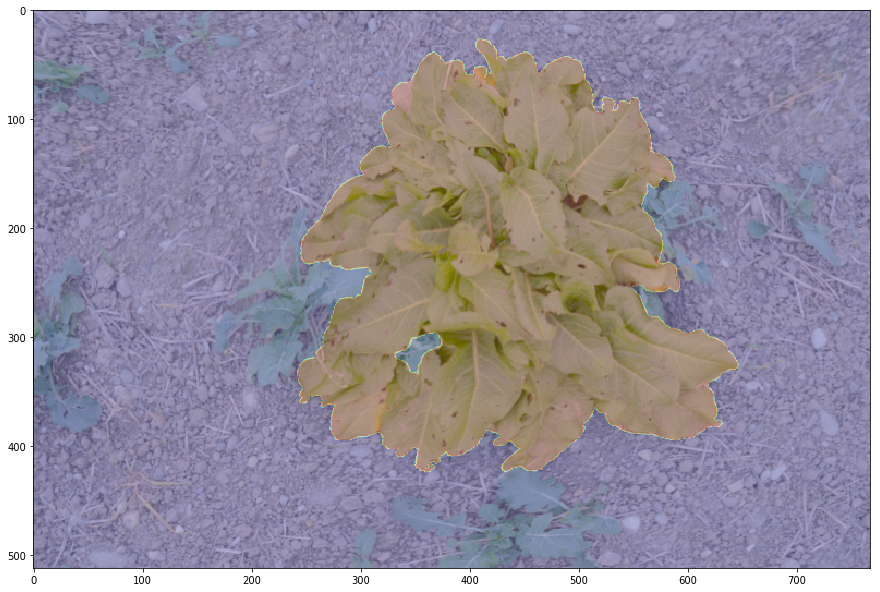

In [32]:
ind = 0
plt.figure(figsize=(15,15))
imshow(ims_aug[0].images_aug[ind])
imshow(msks_aug[0].images_aug[ind],cmap='jet',alpha=0.3)